# ***Path and Dependencies***

In [114]:
''' 
drive link : https://drive.google.com/drive/folders/1JIHX5NkYCbDxlEH2fiOGNrM5DA2X6p2d?usp=share_link

1. Access the datasets using the above line.
2. Copy the path of folder "Images" and assign it to variable PATH.
3. GitHub repo (for guidance): https://github.com/tavgreen/landuse_classification  
'''

' \ndrive link : https://drive.google.com/drive/folders/1JIHX5NkYCbDxlEH2fiOGNrM5DA2X6p2d?usp=share_link\n\n1. Access the datasets using the above line.\n2. Copy the path of folder "Images" and assign it to variable PATH.\n3. GitHub repo (for guidance): https://github.com/tavgreen/landuse_classification  \n'

In [115]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [116]:
PATH = '/Users/vishwanathanayyappan/Documents/0. Projects/ISRO/UCMerced_LandUse/Images'

# ***EDA***

In [117]:
dirs = sorted(os.listdir(PATH)) # list of all class names (file names in PATH)
dirs

['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'denseresidential',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mediumresidential',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'river',
 'runway',
 'sparseresidential',
 'storagetanks',
 'tenniscourt']

In [118]:
first_img_list = [] # stores path of first image in all categories
img_per_class = []  # stores no. of images in each class
for i in dirs:
    cc = os.path.join(PATH, i)
    n = len(os.listdir(cc))
    img_per_class.append(n)
    first_img = os.path.join(cc, sorted(os.listdir(cc))[0]) # [i], where i is i'th images in a class(sorted)
    first_img_list.append(first_img) 

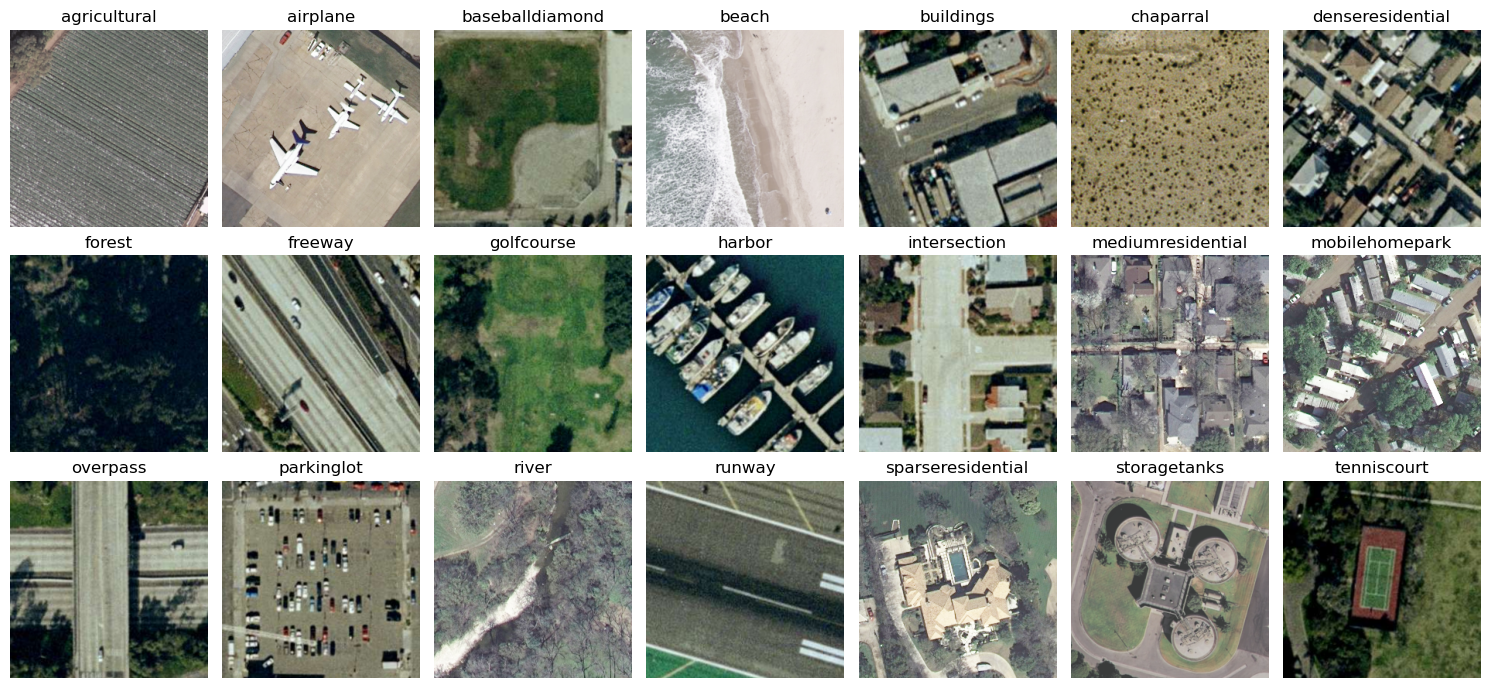

In [119]:
num_images = len(first_img_list)
num_cols = 7  
num_rows = -(-num_images // num_cols) 

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 7))

for i, (path, image_name) in enumerate(zip(first_img_list, dirs)):
    row = i // num_cols
    col = i % num_cols
    img = Image.open(path)
    ax[row, col].imshow(img)
    ax[row, col].set_title(image_name)  
    ax[row, col].axis('off')


plt.tight_layout()
plt.show()


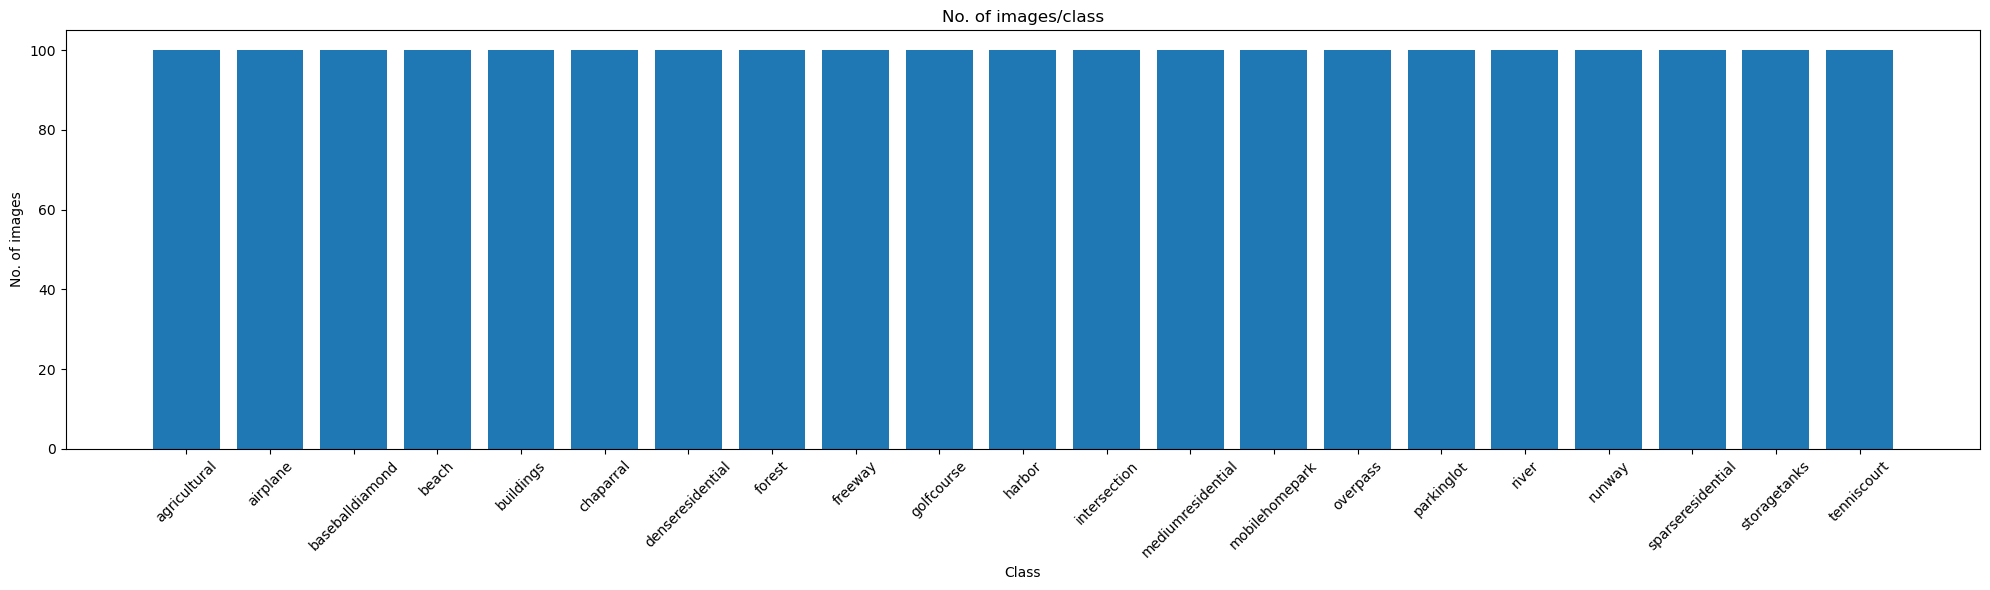

In [120]:
plt.figure(figsize=(20, 6))
plt.bar(dirs, img_per_class) 

plt.xlabel('Class')
plt.ylabel('No. of images')
plt.title('No. of images/class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ***Train and Test dataset preparation***

In [121]:
x_train = []
y_train = []

x_test = []
y_test = []

for i in dirs:
    count = 0
    current_class = os.path.join(PATH,i)
    pics = sorted(os.listdir(current_class))
    
    for pic in pics:
        img = Image.open(os.path.join(current_class, pic))
        img = np.array(img)
        if((np.shape(img)[0] == 256 and np.shape(img)[1] == 256) and count < 100):
            r_chl = img[:,:,0]
            g_chl = img[:,:,1]
            b_chl = img[:,:,2]

            if(count < 15):  # first 15 examples in a class are taken for test
                x_test.append([r_chl, g_chl, b_chl])
                y_test.append([dirs.index(i)])
            else:            # rest 85 are taken as train examples
                x_train.append([r_chl, g_chl, b_chl])
                y_train.append([dirs.index(i)])
                 
            count = count + 1

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [122]:
x_train = x_train.astype('float32') # shape = (1785, 3, 256, 256) 
x_test = x_test.astype('float32')   # shape = (105, 3, 256, 256) 

'''
a CNN model accepts input_shape = (no. of train examples, rows, columns, channels)
but the order above is  (no. of train examples, channels, rows, columns)
hence the variables are transposed accordingly 
'''

x_train = np.transpose(x_train, (0,2,3,1)) # shape = (1785, 256, 256, 3) 
x_test = np.transpose(x_test, (0,2,3,1))    # shape = (105, 256, 256, 3) 

'''
here the 4D dataset is normalized via broadcasting 
'''
x_train = x_train/ 255.0
x_test = x_test/ 255.0

y_train = tf.keras.utils.to_categorical(y_train, 21)
y_test = tf.keras.utils.to_categorical(y_test, 21)

In [123]:
np.shape(x_train)

(1741, 256, 256, 3)

# ***Model & Training***

In [124]:
class myCallback(tf.keras.callbacks.Callback):  # callbacks to stop before overfitting 
  def on_epoch_end(self, epoch, logs={}): # on_epoch_end is used due to fluctuating loss across epochs
    
    if(logs.get('val_accuracy') > 0.44):
      print("\n\n Accuracy is greater than 0.44 so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [125]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu, input_shape = (256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation = tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dropout(0.45),
    tf.keras.layers.Dense(21, activation = tf.nn.softmax)
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 30, 30, 32)      

In [126]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.optimizers.Adam(),
    metrics = ['accuracy']
)

In [127]:
result = model.fit(x_train, y_train, batch_size=75, epochs=10, verbose=1, validation_data=(x_test, y_test), callbacks=[callbacks])

Epoch 1/10


2023-08-30 23:43:14.235050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 3.0312 - accuracy: 0.0517

2023-08-30 23:43:28.076024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 15s 417ms/step - loss: 3.0312 - accuracy: 0.0517 - val_loss: 2.9421 - val_accuracy: 0.0603
Epoch 2/10
24/24 [==============================] - 8s 347ms/step - loss: 2.8681 - accuracy: 0.1235 - val_loss: 2.8437 - val_accuracy: 0.1683
Epoch 3/10
24/24 [==============================] - 8s 349ms/step - loss: 2.5862 - accuracy: 0.2343 - val_loss: 2.6980 - val_accuracy: 0.1873
Epoch 4/10
24/24 [==============================] - 8s 342ms/step - loss: 2.1882 - accuracy: 0.3665 - val_loss: 2.4818 - val_accuracy: 0.2444
Epoch 5/10
24/24 [==============================] - 8s 348ms/step - loss: 1.6166 - accuracy: 0.4980 - val_loss: 2.4283 - val_accuracy: 0.2730
Epoch 6/10
24/24 [==============================] - 8s 348ms/step - loss: 1.1948 - accuracy: 0.6318 - val_loss: 2.4595 - val_accuracy: 0.3302
Epoch 7/10
24/24 [==============================] - 8s 347ms/step - loss: 0.8933 - accuracy: 0.7209 - val_loss: 2.2009 - val_accuracy: 0.3873
Epoch 8/10
24/24

# ***Performance***

In [128]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('\nTesting loss: {}, acc: {}\n'.format(loss, accuracy))


Testing loss: 2.5697503089904785, acc: 0.37142857909202576



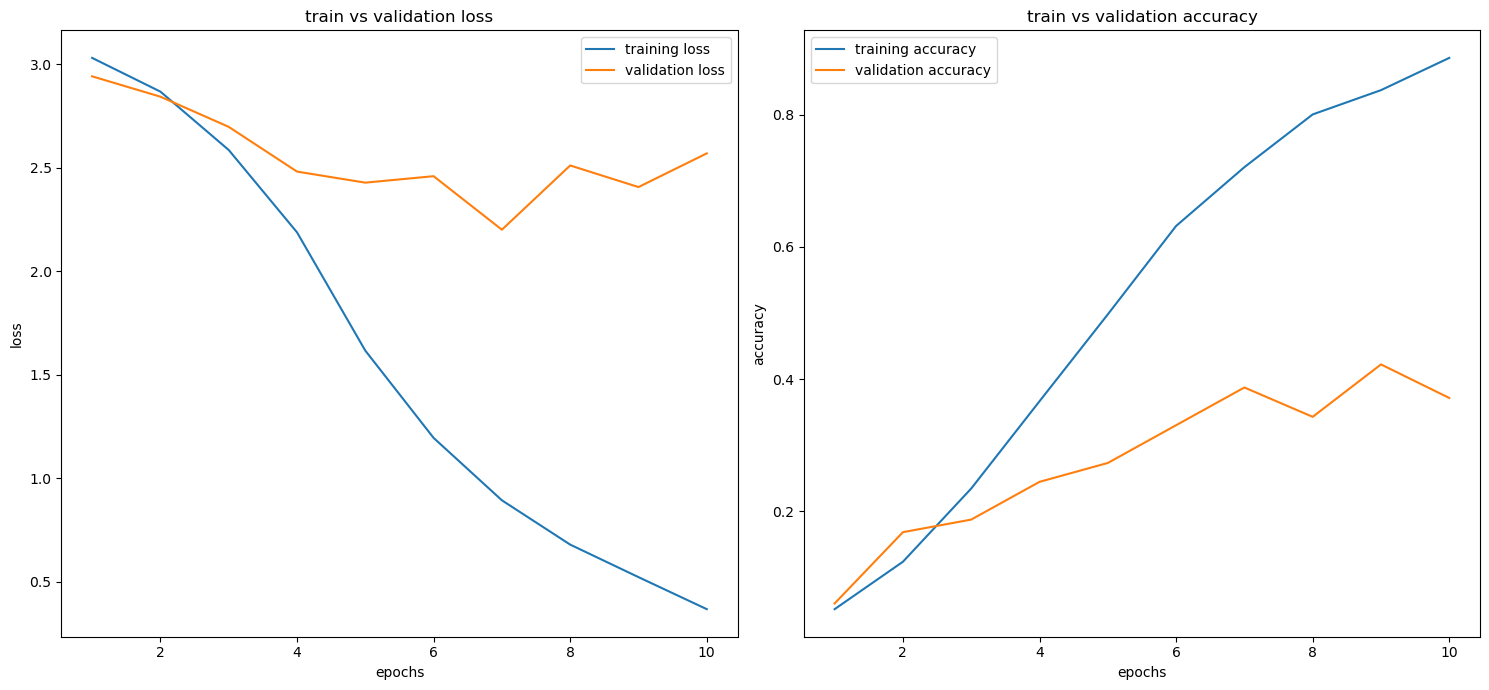

In [129]:

fig, axs = plt.subplots(1, 2, figsize=(15,7))


axs[0].plot(range(1, len(result.history['loss']) + 1), result.history['loss'], label='training loss')
axs[0].plot(range(1, len(result.history['loss']) + 1), result.history['val_loss'], label='validation loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].set_title('train vs validation loss')
axs[0].legend()


axs[1].plot(range(1, len(result.history['loss']) + 1), result.history['accuracy'], label='training accuracy')
axs[1].plot(range(1, len(result.history['loss']) + 1), result.history['val_accuracy'], label='validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_title('train vs validation accuracy')
axs[1].legend()


plt.tight_layout()
plt.show()


# ***Image Data Generator***

In [130]:
np.shape(x_train)

(1741, 256, 256, 3)

In [131]:
IDG = ImageDataGenerator(
    rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)

In [132]:
IDG.fit(x_train)

In [133]:
'''
The following contains the results upon introducting image augmentation
Total training examples = 1741
batch_size = 75
epochs = 10

total agumented images = (1741/75)*10 = 232
'''

'\nThe following contains the results upon introducting image augmentation\nTotal training examples = 1741\nbatch_size = 75\nepochs = 10\n\ntotal agumented images = (1741/75)*10 = 232\n'

In [134]:
result_IDG = model.fit(datagen.flow(x_train, y_train, batch_size=75), epochs = 10, verbose = 1, validation_data = (x_test, y_test))

Epoch 1/10


2023-08-30 23:44:47.743169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-30 23:44:47.998644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 23s 871ms/step - loss: 2.1124 - accuracy: 0.4113 - val_loss: 1.9876 - val_accuracy: 0.3270
Epoch 2/10
24/24 [==============================] - 22s 899ms/step - loss: 1.7309 - accuracy: 0.4670 - val_loss: 1.7894 - val_accuracy: 0.4063
Epoch 3/10
24/24 [==============================] - 22s 915ms/step - loss: 1.5600 - accuracy: 0.5135 - val_loss: 2.0105 - val_accuracy: 0.4127
Epoch 4/10
24/24 [==============================] - 21s 877ms/step - loss: 1.5100 - accuracy: 0.5296 - val_loss: 1.7729 - val_accuracy: 0.4476
Epoch 5/10
24/24 [==============================] - 22s 911ms/step - loss: 1.3494 - accuracy: 0.5761 - val_loss: 1.7152 - val_accuracy: 0.4698
Epoch 6/10
24/24 [==============================] - 21s 876ms/step - loss: 1.2165 - accuracy: 0.6157 - val_loss: 1.6313 - val_accuracy: 0.4984
Epoch 7/10
24/24 [==============================] - 21s 874ms/step - loss: 1.1660 - accuracy: 0.6140 - val_loss: 1.6248 - val_accuracy: 0.4794
Epoch 8/10

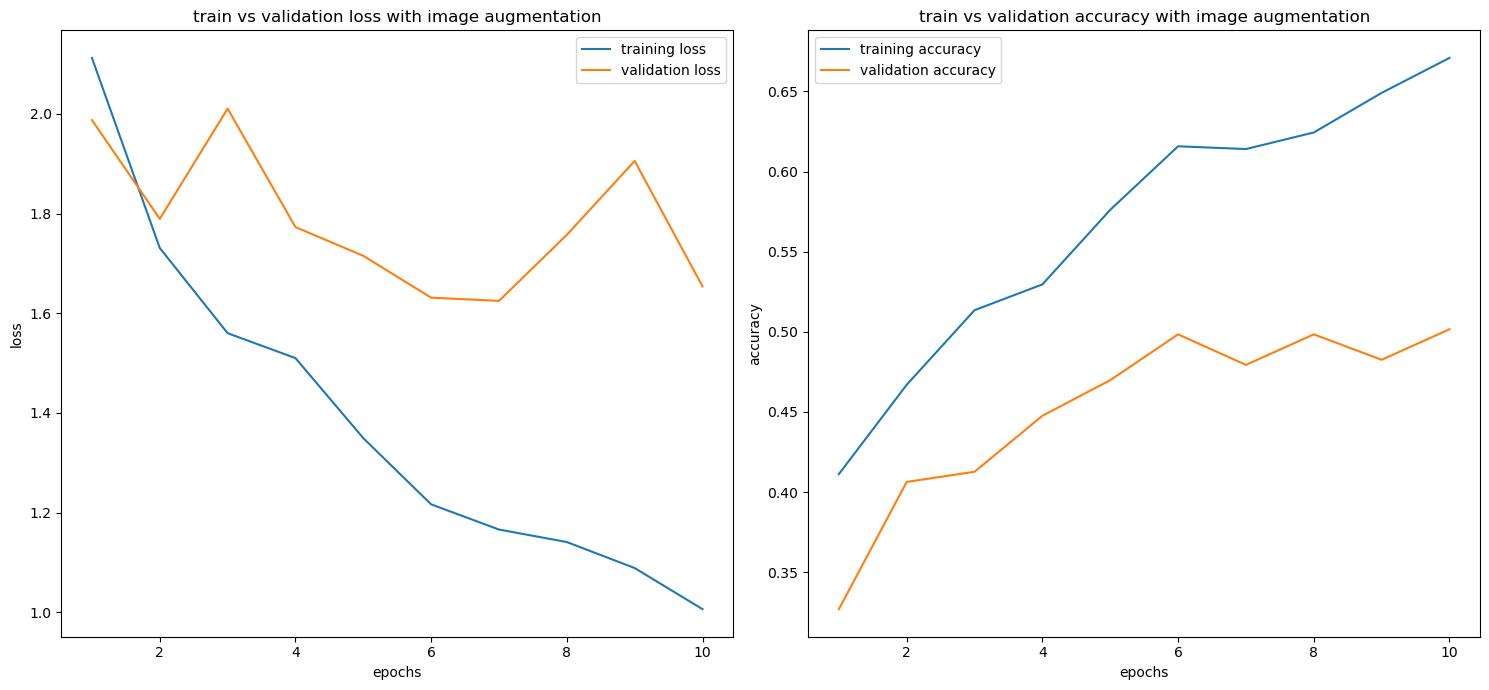

In [135]:

fig, axs = plt.subplots(1, 2, figsize=(15,7))


axs[0].plot(range(1, len(result_IDG.history['loss']) + 1), result_IDG.history['loss'], label='training loss')
axs[0].plot(range(1, len(result_IDG.history['loss']) + 1), result_IDG.history['val_loss'], label='validation loss')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
axs[0].set_title('train vs validation loss with image augmentation')
axs[0].legend()


axs[1].plot(range(1, len(result_IDG.history['loss']) + 1), result_IDG.history['accuracy'], label='training accuracy')
axs[1].plot(range(1, len(result_IDG.history['loss']) + 1), result_IDG.history['val_accuracy'], label='validation accuracy')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
axs[1].set_title('train vs validation accuracy with image augmentation')
axs[1].legend()


plt.tight_layout()
plt.show()
